# Stochastic Modeling

Here, we're going to work through some basic stochastic modeling using the Moran process. 


### Document Setup

First, we'll import the necessary libraries and adjust naming appropriately

In [64]:
import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
import timeit
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline

## Neutral Moran

Let's start with looking at neutral moran process and the time to fixation based on starting populations. 

In [2]:
def neutral_moran(N, i=1, seed=0):
    """
    Return the population counts for the Moran process with neutral drift.
    """

    population = [0 for _ in range(i)] + [1 for _ in range(N - i)]
    # print(population)
    counts = {"wt": population.count(0), "mutant": population.count(1)}
    counts = pd.DataFrame(counts, index=[0])
    np.random.seed(seed)
    while len(set(population)) == 2:
        reproduce_index = np.random.randint(N)
        eliminate_index = np.random.randint(N)
        # Replace random population member with the allele of the member chosen to reproduce
        population[eliminate_index] = population[reproduce_index]
        new_counts = {"wt": population.count(0), 
                      "mutant": population.count(1)}
        counts = counts.append(new_counts, ignore_index=True)
    return counts

And we'll run it with a starting population of 10, split equally between each allele. In the plot below, blue represents wild-type while orange represents the mutatant allele. 

In [3]:
N = 10
neutral_counts = neutral_moran(N=N, i=5, seed=2020)

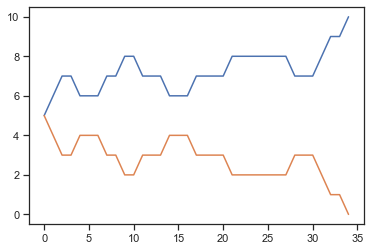

In [4]:
plt.plot(neutral_counts);

In [5]:
def neutral_fixation(N, i=None, repetitions=10):
    """
    Repeat the neutral Moran process and calculate the fixation probability
    """
    fixation_count = 0
    for seed in range(repetitions):
        final_counts = neutral_moran(N=N, i=i, seed=seed)
        # if final_counts[-1][0] > 0:
        if final_counts.iloc[-1][0] > 0:
            fixation_count += 1 
    return  fixation_count / repetitions 

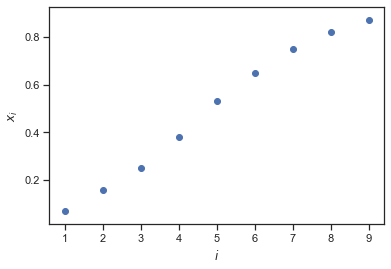

In [6]:
probabilities = [neutral_fixation(N, i=i, repetitions=100) for i in range(1, N)]
plt.scatter(range(1, N), probabilities)
plt.xlabel("$i$")
plt.ylabel("$x_i$");

## Moran with Selection

Now, let's change the fitness of alleles. First, we'll start by defining a moran process function that takes sample size, initial wt allele starting size, fitness of mutant allele (ratio between mutant and wt allele), a set amount of time steps, and a seed.

In [47]:
def moran_selection(N, i=None, fitness = 1.5, time_steps = 5000, seed = 0, stopFixation = False):
    """
    Return the population counts for the Moran process with selection due to differences in allele fitness.
    """
    population = [0 for _ in range(i)] + [1 for _ in range(N - i)]
    count1 = [population.count(1)] # initialize list of mutant allele counts
    np.random.seed(seed)
    # while len(set(population)) == 2: # if you want it to run until fixation, use this instead of time
    time = 1
    while time < (time_steps): # cutoff for how many steps we'll do
        time += 1
        scores = []
        for count, i in enumerate(population): # change all 0's to 1 and all 1's to the fitness value
            if i == 0: 
                scores.append(1)
            if i == 1: 
                scores.append(fitness)
        total_score = sum(scores)
        probabilities = [score/total_score for score in scores] # convert fitness scores into probabilities
        reproduce_index = np.random.choice(range(N), p=probabilities) # choose which individual to reproduce weighted by fitness score
        eliminate_index = np.random.randint(N) # who gets eliminated is completely random still
        population[eliminate_index] = population[reproduce_index] # replace eliminated individual with reproduced individual
        count1.append(population.count(1)) # update counts for this timestep with the current mutant allele count
        # Setting stopFixation to true will stop the run once an allele reaches 
        # fixation even if it's before the set timesteps
        if stopFixation == True:
            if len(set(population)) < 2:
                break
    return [count/N for count in count1] # return as proportion

2

### Timing moran selection function

Here, we're going to determine how long it takes to run the moran function 10 over 5000 generations, with a fitness of 1.1, and a population size of 10, 100, and 1000. We'll take the average time of 10 runs (where each run is a the resulting time to perform the simulation 10 times). 

In [68]:
def moran_time(): 
    # import moran_selection function to timing environment
    SETUP_CODE = ''' 
from __main__ import moran_selection 
    '''
    
    # setup function runs with parameters of interest (population size sweep)
    TEST_CODE_N10 = ''' 
moran_selection(N = 10, i = 5, fitness = 1.1, time_steps = 5000)
    '''
    TEST_CODE_N100 = ''' 
moran_selection(N = 100, i = 50, fitness = 1.1, time_steps = 5000)
    '''
    
    TEST_CODE_N1000 = ''' 
moran_selection(N = 1000, i = 500, fitness = 1.1, time_steps = 5000)
    '''
    
    # timeit.repeat statement N = 10
    times10 = timeit.repeat(setup = SETUP_CODE, 
                          stmt = TEST_CODE_N10, 
                          repeat = 10, 
                          number = 10) 
  
    # priniting minimum exec. time 
    print('N = 10: {}'.format(statistics.mean(times10)))   
    
        # timeit.repeat statement N = 100
    times100 = timeit.repeat(setup = SETUP_CODE, 
                          stmt = TEST_CODE_N100, 
                          repeat = 10, 
                          number = 10) 
  
    # priniting minimum exec. time 
    print('N = 100: {}'.format(statistics.mean(times100)))  
    
        # timeit.repeat statement N = 1000
    times1000 = timeit.repeat(setup = SETUP_CODE, 
                          stmt = TEST_CODE_N1000, 
                          repeat = 10, 
                          number = 10) 
  
    # priniting minimum exec. time 
    print('N = 1000: {}'.format(statistics.mean(times1000)))  
  
moran_time() 

N = 10: 2.1903443159000746
N = 100: 3.726267480700153
N = 1000: 19.090994177000177


### Mutant Allele Frequency Over Time

Let's look at how the mutant allele frequency changes over time. 

We'll use an example of a single run, starting with a population of 1000 (starting 50/50 between wt/mutant allele), where the mutant allele has a fitness ratio of 2:1 compared to the wild type. We'll run it for 20000 timesteps. If `stopFixation = False`, it will run all 20,000 steps. If `stopFixation = True`, the function will stop once an allele becomes fixed or at 20,000 timesteps (whichever comes first). 

In [8]:
mut_prop = moran_selection(N = 1000, i = 500, fitness = 2, time_steps = 20000, seed = 2020, stopFixation = True)

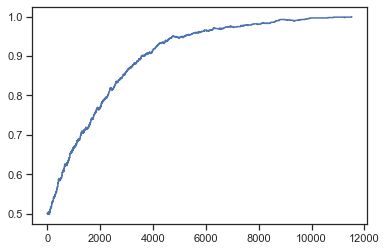

In [9]:
plt.plot(mut_prop);

We'll examine how the mutant allele frequency changes when the moran process is run over a range of starting sample sizes and fitnesses. Additionally, we'll run each parameter combination `sim_n` times in order to gather variance data.

In [10]:
def mut_freq_timesteps(N_range, fitness_range, sim_n, time_steps):
    """ 

    The results contain a dataframe (timesteps x simulation num) for 
    each unique combination N_range and fitness_range. 

    """
    results_df = pd.DataFrame(columns = ["timepoint", "mut_prop", "pop_size", "fitness"])
    
    for i, N in enumerate(N_range):
        for j, fitness in enumerate(fitness_range):
            sim_dict = {}
            for sim in range(sim_n):
                # run moran algorithm to extract mutant allele frequency after time_steps
                mut_prop = moran_selection(N = N, 
                                         i = round(N/2), 
                                         fitness = fitness, 
                                         time_steps = time_steps, 
                                         seed = sim)
                sim_dict[sim] = mut_prop # build a dictionary of simulation entries
            # Make df with cols=timesteps and rows = simulation n
            sim_df = pd.DataFrame.transpose(pd.DataFrame(sim_dict))
            # Melt df to have col for timepoint and col for mutation proportion
            sim_df = pd.melt(sim_df, var_name = "timepoint", value_name = "mut_prop")
            sim_df['pop_size'] = [str(N)] * sim_n * time_steps # new column with N (population size) value
            sim_df['fitness'] = [str(fitness)] * sim_n * time_steps # new column with fitness value
            results_df = results_df.append(sim_df)
    return(results_df)

### Moran selection mutant frequency parameter sweep

In [11]:
time_steps = 5000

fitness_range = [0.5, 0.75, 0.9, 0.99, 1, 1.01, 1.1, 1.5, 2] #fitness ratio of mutant:wt allele
N_range = [100, 1000] # population size
sim_n = 20 # how many times we run the same simulation with different seeds

In [12]:
# mut_freq_100steps = mut_freq_timesteps(N_range = N_range, fitness_range = fitness_range,
#                                   sim_n = sim_n, time_steps = 100)

In [13]:
# mut_freq_5000steps = mut_freq_timesteps(N_range = N_range, fitness_range = fitness_range,
#                                   sim_n = sim_n, time_steps = 5000)
# mut_freq_5000steps.to_csv("Results/mut_freq_5000steps.csv", index=False)

In [14]:
mut_freq_5000steps = pd.read_csv("Results/mut_freq_5000steps.csv")

Let's take a look at what these results look like. We'll see that there's 20 entries (`sim_n`) containing the mutant allele frequency for each parameter combination, at each timestep,

In [15]:
mut_freq_5000steps.tail()

# mut_freq_5000steps.shape[0]

,timepoint,mut_prop,pop_size,fitness
1799995,4999,0.937,1000,2.0
1799996,4999,0.953,1000,2.0
1799997,4999,0.954,1000,2.0
1799998,4999,0.938,1000,2.0
1799999,4999,0.928,1000,2.0


Now, let's plot the results of this parameter sweep. Using seaborn, this takes a significant amount of time for the dataframe containing 5000 timesteps for each parameter, which is why we also have a dataframe contianing only 100 timesteps. 

Below, we'll make a separate plot demonstrating how the mutant allele frequency changes over time for each population size. The confidence intervals represent variation between simulations, and they are automaticaly calculated because there are multiple samples (simulations) for each parameter combination. 

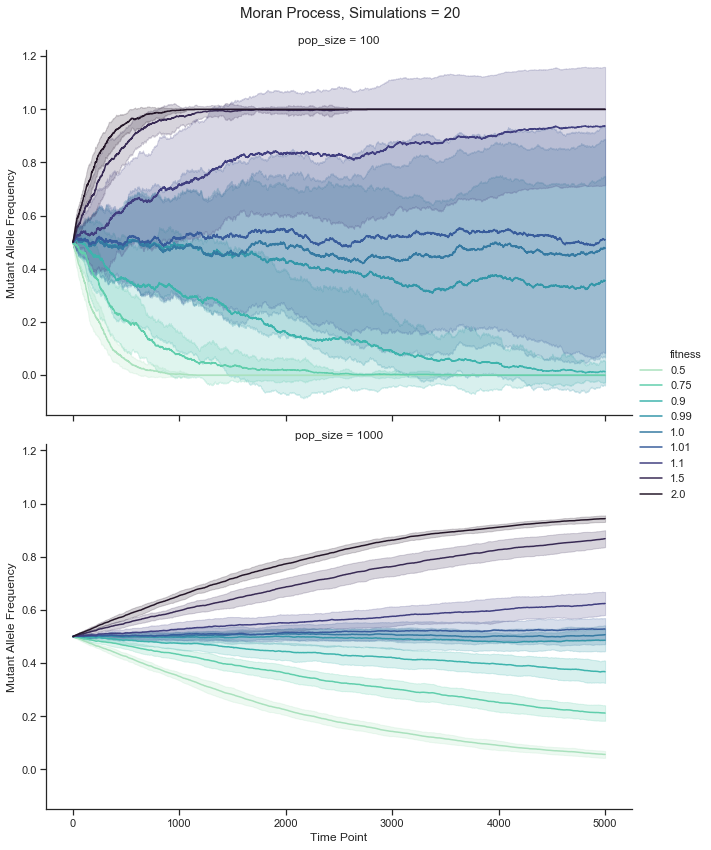

In [16]:
s = [.25, .75, 2, 4]

g = sns.relplot(x="timepoint", y="mut_prop", row="pop_size", ci = "sd", 
                  palette = sns.color_palette("mako_r", len(fitness_range)), 
                  hue = "fitness", kind = "line", height = 6, aspect = 1.5,
                  data=mut_freq_5000steps)
plt.subplots_adjust(top=0.93) # adjusts main title to not overlap with subtitles
g.fig.suptitle("Moran Process, Simulations = 20", fontsize=15)
g.set_axis_labels(x_var='Time Point', y_var='Mutant Allele Frequency');

### Mutant Time to Fixation


Now we're going to plot time to fixation. Gathering the results will be a function similar to `mut_freq_timesteps`, except we'll set `stopFixation = True` and we'll store the number of timesteps used by each simulation instead of the mutation allele frequencies over time. 

In [17]:
def mut_fix_time(N_range, start_mut_prop, fitness_range, sim_n):
    """ 

    The results contain a dataframe (timesteps x simulation num) for 
    each unique combination N_range and fitness_range. 

    """
    results_df = pd.DataFrame(columns = ["time2fix", "pop_size", "fitness"])
    
    for i, N in enumerate(N_range):
        for j, fitness in enumerate(fitness_range):
            sim_dict = {}
            time_list = []
            for sim in range(sim_n):
                # run moran algorithm to extract mutant allele frequency after time_steps
                if start_mut_prop == "single mutant": # Set i to be N-1 for single mutant starting point
                    mut_prop = moran_selection(N = N, 
                                               i = (N-1), 
                                               fitness = fitness,
 seed = sim,
                                               time_steps = float('inf'),
                                              stopFixation = True)
                    if mut_prop[-1] == 1:
                        time_list.append(len(mut_prop))
                if start_mut_prop == "half": # Set i to be N-1 for single mutant starting point
                    mut_prop = moran_selection(N = N, 
                                               i = round(N/2), 
                                               fitness = fitness,
                                               seed = sim,
                                               time_steps = float('inf'),
                                              stopFixation = True)
                    time_list.append(len(mut_prop))
                 # List all times for each simulation run of a parameter combo
            sim_dict['time2fix'] = [float(i) for i in time_list] # Times to float
            sim_dict['pop_size'] = [N] * len(time_list) # new column with N (population size) value
            sim_dict['fitness'] = [fitness] * len(time_list) # new column with fitness value
            sim_df = pd.DataFrame.from_dict(sim_dict)
            results_df = results_df.append(sim_df)
    return(results_df)

#### Complete Parameter Sweep

First, we'll look at a parameter sweep of both fitness and population size. We'll plot the results of 1000 simulations as boxplots.

In [18]:
fitness_range = [1.1, 1.4, 1.7, 2] #fitness ratio of mutant:wt allele
N_range = [10, 100, 1000] # population size
sim_n = 1000 # how many times we run the same simulation with different seeds

# Quick run
# fitness_range = [5, 10] #fitness ratio of mutant:wt allele
# N_range = [10, 100] # population size
# sim_n = 5 # how many times we run the same simulation with different seeds


# time2fix_results_sweep = mut_fix_time(N_range = N_range, 
#                                       start_mut_prop = "half", 
#                                       fitness_range = fitness_range, 
#                                       sim_n = sim_n)
# time2fix_results_sweep.to_csv("Results/time2fix_parameter_sweep.csv", index=False)

In [19]:
time2fix_results_sweep_test = pd.read_csv("Results/time2fix_parameter_sweep.csv")

In [20]:
time2fix_results_sweep_test['moran_time'] = time2fix_results_sweep_test['time2fix']/time2fix_results_sweep_test['pop_size']

And now, let's plot the distribution time to fixation measurements for all the parameter settings. 

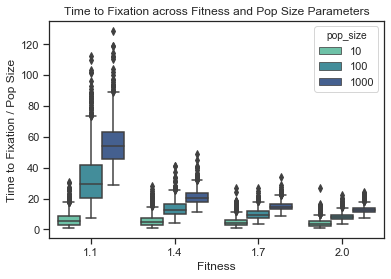

In [21]:
g = sns.boxplot(x="fitness", y="moran_time",
            hue="pop_size", 
            palette=sns.color_palette("mako_r", len(fitness_range)),
            data=time2fix_results_sweep_test)
plt.xlabel("Fitness") 
plt.ylabel("Time to Fixation / Pop Size")
plt.title("Time to Fixation across Fitness and Pop Size Parameters");

#### Mutant Fitness Parameter Sweep

Next, we're going to look at specific parameter values to emulate Figure 3 of the stochastic modeling paper. First, we'll sweep across varying fitnesses of the mutant allele and assess the time to mutant fixation when a population of 50 begins with a single mutant. 

##### Simulation

In [22]:
fitness_range = np.arange(1, 5.2, 0.2) #fitness ratio of mutant:wt allele
N_range = [50] # population size
sim_n = 1000 # how many times we run the same simulation with different seeds

# time2fix_results_fit_sweep = mut_fix_time(N_range = N_range, 
#                                           start_mut_prop = "single mutant", 
#                                           fitness_range = fitness_range, 
#                                           sim_n = sim_n)
# time2fix_results_fit_sweep.to_csv("Results/time2fix_parameter_fit_sweep.csv", index=False)

In [23]:
time2fix_results_fit_sweep = pd.read_csv("Results/time2fix_parameter_fit_sweep.csv")

Let's take a quick look at what our data looks like. It's in a long format with a column designating the population size (`pop_size`), a column for the fitness advantage of the mutant (`fitness`) and the number of timesteps required for the mutant to reach fixation.

In [24]:
time2fix_results_fit_sweep.tail()

,time2fix,pop_size,fitness
12274,290.0,50,5.0
12275,334.0,50,5.0
12276,272.0,50,5.0
12277,378.0,50,5.0
12278,383.0,50,5.0


##### Analytical

Next, let's create an analytical solution based on the formulas provided for a well-mixed population in Frean et al, 2013.

In [70]:
def prop_wt_repo_analytics(N, j, r):
    """
    Finding T-(j)
    """
    return( ((N-j)/(r*j + N - j) * (j/N)) )

def prop_mut_repo_analytics(N, j, r):
    """
    Finding T+(j)
    """
    return( ((r*j)/(r*j + N - j)) * ((N-j)/N) )

# def prob_fixation_analytics()

##### Visualization

Finally, we'll plot how the average time to fixation changes as the fitness of the mutant allele increases below. 

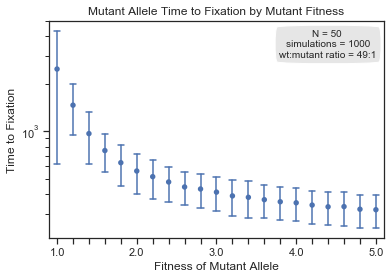

In [25]:
# Create plot
ax = sns.pointplot(x = 'fitness', y ='time2fix',
                  ci="sd",
                  markers = ".",
                  errwidth = 1.5,
                  capsize = 0.4,
                  join = False,
                  data=time2fix_results_fit_sweep)

# Log scale y-axis
ax.set(yscale="log")

# Reset axis tick labels (this prevents weird rounding error for tick labels:)
x_ticks = ['{:.1f}'.format(x) for x in fitness_range] # convert fitnesses to list of strings

for i,l in enumerate(x_ticks):
    if(i%5 != 0): x_ticks[i] = '' # skip non-int labels

ax.set_xticklabels(x_ticks) 


# Annotate plot
an1 = ax.annotate("N = {} \nsimulations = {}\nwt:mutant ratio = 49:1".format(N_range[0], sim_n), 
                  xy=(17, 3550), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))

# Fine tune plot
plt.title("Mutant Allele Time to Fixation by Mutant Fitness")
plt.xlabel("Fitness of Mutant Allele")
plt.ylabel("Time to Fixation");

#### Population size (N) parameter sweep

Next, we'll look at how time to fixation varies with population size. Again, we'll start with simulations, then examine the analytical solution. 

##### Simulation

In [26]:
fitness_range = [1.1] #fitness ratio of mutant:wt allele
N_range = np.arange(5, 105, 5) # population size
sim_n = 1000 # how many times we run the same simulation with different seeds

# time2fix_results_N_sweep = mut_fix_time(N_range = N_range, 
#                                         start_mut_prop = "single mutant", 
#                                         fitness_range = fitness_range, 
#                                         sim_n = sim_n)
# time2fix_results_N_sweep.to_csv("Results/time2fix_parameter_N_sweep.csv", index=False)

In [27]:
time2fix_results_N_sweep = pd.read_csv("Results/time2fix_parameter_N_sweep.csv")

In [28]:
time2fix_results_N_sweep.tail()

,time2fix,pop_size,fitness
2129,6391.0,100,1.1
2130,7174.0,100,1.1
2131,3972.0,100,1.1
2132,3460.0,100,1.1
2133,5324.0,100,1.1


##### Analytical

Next, let's create an analytical solution based on the formulas provided for a well-mixed population in Frean et al, 2013.

##### Visualization

Finally, we'll plot how time to mutant fixation changes with a varying population size. 

In [ ]:
# Plot fixation probability across selective advantage parameter sweep
ax = sns.pointplot(x = 'pop_size', y ='time2fix',
                   ci="sd",
                   markers = ".",
                   errwidth = 1.5,
                   capsize = 0.4,
                   join = False,
                   data=time2fix_results_N_sweep)

# Add annotations
an1 = ax.annotate("Fitness = {} \nsimulations = {}\nwt:mutant ratio = 49:1".format(fitness_range[0], sim_n), 
                  xy=(16.2, 13), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))

# Log scale y-axis
ax.set(yscale="log")


# Fine tune plot
plt.title("Mutant Allele Time to Fixation by Population Size")
plt.xlabel("Population Size")
plt.ylabel("Time to Fixation");

### Probability of Mutant Fixation

Now, let's make a function to determine the probability of mutant fixation across parameters of a moran selection process. 

#### Fitness parameter sweep

##### Simulation

In [30]:
def selection_fixation_byFit(N, fit_start, fit_stop, step, reps=10):
    """
    Repeat the neutral Moran process and calculate the fixation probability
    """
    fitness_lst = []
    fix_prob_lst = []
    fix_prob_err_lst = []
    for f in np.arange(fit_start, fit_stop+step, step):
        fixation_count = 0
        for seed in range(reps):
            mut_prop = moran_selection(N=N, 
                                       i=(N-1),
                                       fitness = f,
                                       time_steps = float('inf'),
                                       seed=seed,
                                       stopFixation = True)
            # if final_counts[-1][0] > 0:
            if mut_prop[-1] == 1:
                fixation_count += 1 
        fitness_lst.append(f)
        fix_prob = fixation_count/reps
        fix_prob_lst.append(fix_prob)
        fix_prob_err_lst.append((math.sqrt((fix_prob*(1-fix_prob))/reps))*2)
    prob_dict = {'fitness': fitness_lst, 
                'fix_prob': fix_prob_lst,
                'fix_error': fix_prob_err_lst}
    return  pd.DataFrame(prob_dict) 

In [31]:
N = 50
reps = 1000

# fix_prob_byFit_results = selection_fixation_byFit(N = N, fit_start = 1, fit_stop = 5, step = 0.2, reps = reps)
# fix_prob_byFit_results.to_csv('Results/fix_prob_byFit_results_N{}sim{}.csv'.format(N,reps), index = False)

In [32]:
fix_prob_byFit_results = pd.read_csv('Results/fix_prob_byFit_results_N{}sim{}.csv'.format(N,reps))

In [33]:
fix_prob_byFit_results.tail()

,fitness,fix_prob,fix_error
16,4.2,0.761,0.026973
17,4.4,0.767,0.026737
18,4.6,0.773,0.026493
19,4.8,0.779,0.026242
20,5.0,0.787,0.025894


##### Analytical

In [85]:
def fix_time_analytics(r, N):
    time = (1 - (1/r**1)) / (1 - (1/r**N))
    return(time)

fix_time_fitness = []

for r in np.arange(1, 5.2, 0.2): 
    fix_time_fitness.append(fix_time_analytics(r = r, N = 50))

fix_prob_byFit_results['analytic_results'] = fix_time_fitness


/Users/jessicascarborough/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [87]:
fix_prob_byFit_results.head()

,fitness,fix_prob,fix_error,analytic_results
0,1.0,0.020,0.008854,NaN
1,1.2,0.170,0.023757,0.166685
2,1.4,0.281,0.028428,0.285714
3,1.6,0.369,0.030518,0.375000
4,1.8,0.448,0.031451,0.444444


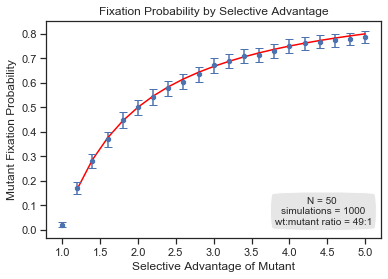

In [90]:
# Plot fixation probability across selective advantage parameter sweep
ax = sns.scatterplot(x = 'fitness', y ='fix_prob', data=fix_prob_byFit_results, ci=None)
ax = sns.lineplot(x="fitness", y="analytic_results", color = "red", data=fix_prob_byFit_results)

# Create error bars
error = fix_prob_byFit_results['fix_error'].tolist()
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax.errorbar(x_coords, y_coords, yerr=error, fmt='o', markersize=4, capsize=4)

# Add annotations
an1 = ax.annotate("N = {} \nsimulations = {}\nwt:mutant ratio = 49:1".format(N, reps), 
                  xy=(4.45, 0.075), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))

# Fine tune plot
plt.title("Fixation Probability by Selective Advantage")
plt.xlabel("Selective Advantage of Mutant")
plt.ylabel("Mutant Fixation Probability");

#### Fitness probability across population size parameter sweep
And finally, we'll look at how the probability of the mutant allele fixating changes with population size. 

##### Simulation

In [35]:
def selection_fixation_byPopN(N_start, N_stop, step, fitness, reps=10):
    """
    Repeat the neutral Moran process and calculate the fixation probability
    """
    N_lst = []
    fix_prob_lst = []
    fix_prob_err_lst = []
    for N in np.arange(N_start, N_stop+step, step):
        fixation_count = 0
        for seed in range(reps):
            mut_prop = moran_selection(N=N, 
                                       i=(N-1),
                                       fitness = fitness,
                                       time_steps = float('inf'),
                                       seed=seed,
                                       stopFixation = True)
            # if final_counts[-1][0] > 0:
            if mut_prop[-1] == 1:
                fixation_count += 1 
        N_lst.append(N)
        fix_prob = fixation_count/reps
        fix_prob_lst.append(fix_prob)
        # Calculate standard error of a the proportion
        fix_prob_err_lst.append((math.sqrt((fix_prob*(1-fix_prob))/reps))*2)
    prob_dict = {'N': N_lst, 
                'fix_prob': fix_prob_lst,
                'fix_error': fix_prob_err_lst}
    return  pd.DataFrame(prob_dict) 

In [36]:
fitness = 1.1
reps = 1000

# fix_prob_byPop_results = selection_fixation_byPopN(N_start = 5, N_stop = 100, step = 5, fitness = fitness, reps = reps)
# fix_prob_byPop_results.to_csv('Results/fix_prob_byPop_results_fit{}sim{}.csv'.format(fitness, reps), index = False)

In [37]:
fix_prob_byPop_results = pd.read_csv('Results/fix_prob_byPop_results_fit{}sim{}.csv'.format(fitness, reps))

In [92]:
fix_prob_byPop_results.tail()

,N,fix_prob,fix_error,analytic_results
15,80,0.076,0.016760,0.09169
16,85,0.100,0.018974,0.09169
17,90,0.084,0.017544,0.09169
18,95,0.091,0.018190,0.09169
19,100,0.084,0.017544,0.09169


##### Analytical

In [95]:
fix_time_N = []

for N in np.arange(5, 105, 5): 
    fix_time_N.append(fix_time_analytics(r = 1.1, N = N))

fix_prob_byPop_results['analytic_results'] = fix_time_N

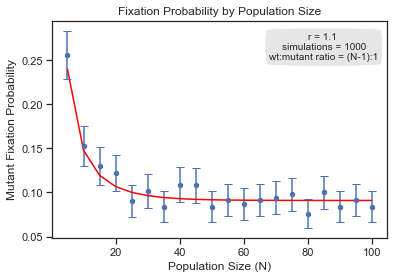

In [96]:
# Plot fixation probability across selective advantage parameter sweep
ax = sns.scatterplot(x = 'N', y ='fix_prob', data=fix_prob_byPop_results, ci=None)
ax = sns.lineplot(x="N", y="analytic_results", color = "red", data=fix_prob_byPop_results)

# Create error bars
error = fix_prob_byPop_results['fix_error'].tolist()
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax.errorbar(x_coords, y_coords, yerr=error, fmt='o', markersize=4, capsize=4)

# Add annotations
an1 = ax.annotate("r = {} \nsimulations = {}\nwt:mutant ratio = (N-1):1".format(fitness, reps), 
                  xy=(85, 0.265), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="round4,pad=.5", fc="0.9"))

# Fine tune labels
plt.title("Fixation Probability by Population Size")
plt.xlabel("Population Size (N)")
plt.ylabel("Mutant Fixation Probability");